# Import libraries

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join
from tabulate import tabulate

# Class for SPAM Filter

In [49]:
""" SPAM Filter using Naive Bayes Classifier algorithm

    Attributes:
        spammicityProbability: Hash table with the spammicity probability of each word
        spamData: Hash table with the frequency of each word in the spam files
        notspamData: Hash table with the frequency of each word in the not spam files
        pUnseen: Probability of unseen word
        threshold: Threshold for classifying a file as SPAM or NOT SPAM
        N: Number of lexemes
"""
class SPAMFilter:
    spammicityProbability = {}
    spamData = {}
    notspamData = {}

    """ 
        Constructor of the class
        Args:
            pUnseen: Probability of unseen word
            threshold: Threshold for classifying a file as SPAM or NOT SPAM
            N: Number of lexemes
    """
    def __init__(self, pUnseen = 0.4, threshold = 0.9, N=16):
        self.pUnseen = pUnseen
        self.threshold = threshold
        self.N = N


    """ 
        Read files from spam and notspam folder and store the data frequency in two hash tables

        Args:
            spamFolder: Path of the spam folder
            notspamFolder: Path of the not spam folder

        Returns:
            None
    """
    def readDataFromFolders(self, spamFolder, notspamFolder):
        # Get the list of files in the spam and notspam folder
        spamFileList = [f for f in listdir(spamFolder) if isfile(join(spamFolder, f))]
        notspamFileList = [f for f in listdir(notspamFolder) if isfile(join(notspamFolder, f))]

        # Read the content of each file and store the data frequency in two hash tables
        for file in spamFileList:
            with open(spamFolder + '/' + file, 'r', encoding="cp437") as f:
                # Split the content of the file by non alphanumeric characters and not !@$&
                content = re.split(r'[^\w\d!@$&]', f.read())
                for word in content:
                    if word != '':
                        if word in self.spamData:
                            self.spamData[word] += 1
                        else:
                            self.spamData[word] = 1

        for file in notspamFileList:
            with open(notspamFolder + '/' + file, 'r', encoding="cp437") as f:
                # Split the content of the file by non alphanumeric characters and not !@$&
                content = re.split(r'[^\w\d!@$&]', f.read())
                for word in content:
                    if word != '':
                        if word in self.notspamData:
                            self.notspamData[word] += 1
                        else:
                            self.notspamData[word] = 1

    """ 
        Get the total number of words in the spam and not spam files

        Args:
            None

        Returns:
            spamTotal: Total number of words in the spam files
            notspamTotal: Total number of words in the not spam files
    """
    def getTotalWords(self):
        spamTotal = 0
        notspamTotal = 0
        for key in self.spamData:
            spamTotal += self.spamData[key]
        for key in self.notspamData:
            notspamTotal += self.notspamData[key]
        return spamTotal, notspamTotal
    
    """  
        Get the frequency of a word in the spam and not spam files
        
        Args:
            word: Word to get the frequency

        Returns:
            spamFrequency: Frequency of the word in the spam files
            notspamFrequency: Frequency of the word in the not spam files
    """    
    def getWordFrequency(self, word):
        spamFrequency = 0
        notspamFrequency = 0
        if word in self.spamData:
            spamFrequency = self.spamData[word]
        if word in self.notspamData:
            notspamFrequency = self.notspamData[word]
        return spamFrequency, notspamFrequency
    

    """
        Write the spammicity probability of each word in a file

        Args:
            file: File to write the spammicity probability

        Returns:
            None
    """
    def writeSpammicityProbability(self, file):
        with open(file, 'w') as f:
            for key in self.spamData:
                # Get the spam frequency and not spam frequency of the word
                spamFrequency, notspamFrequency = self.getWordFrequency(key)

                # Calculate the spammicity probability
                if spamFrequency == 0:
                    spammicityProbability = 0.01 # To avoid 0 probability
                elif notspamFrequency == 0:
                    spammicityProbability = 0.99 # To avoid 1 probability
                else:
                    spammicityProbability = spamFrequency / (spamFrequency + notspamFrequency)

                if key != "":
                    # Write the result in the file
                    f.write(key + ";" + str(spammicityProbability) + "\n")
                    self.spammicityProbability[key] = spammicityProbability


    """
        Read the spammicity probability of each word from a file and store it in a hash table

        Args:
            file: File to read the spammicity probability

        Returns:
            None
    """
    def readDataFromSpamicityFile(self, file):
        with open(file, 'r') as f:
            for line in f:
                line = line.strip()
                key, value = line.split(";")
                self.spammicityProbability[key] = float(value)

    """
        Get the spammicity probability of each word in a new file

        Args:
            file: File to get the spammicity probability

        Returns:
            spammicityProbabilityFile: Hash table with the spammicity probability of each word in the file
    """
    def getSpammicityProbabilityNewFile(self, file):
        spammicityProbabilityFile = {}
        with open(file, 'r', encoding="cp437") as f:
            for line in f:
                content = re.split(r'[^\w\d!@$&]', line)
                for word in content:
                    if word != '':
                        if word not in self.spammicityProbability:
                            spammicityProbabilityFile[word] = self.pUnseen
                        else:
                            spammicityProbabilityFile[word] = self.spammicityProbability[word]
        return spammicityProbabilityFile

    """
        Get the N lexemes with the highest and lowest spammicity probability of a file

        Args:
            file: File to get the N lexemes with the highest and lowest spammicity probability

        Returns:
            lowestSpammicityProbability: N/2 lexemes with the lowest spammicity probability
            highestSpammicityProbability: N/2 lexemes with the highest spammicity probability
    """
    def getNHighestLowestSpammicityProbability(self, file):
        # Get the spammicity probability of each word in the file
        spammicityProbabilityFile = self.getSpammicityProbabilityNewFile(file)

        # Sort the spammicityProbability hash table by value
        sortedSpammicityProbability = sorted(spammicityProbabilityFile.items(), key=lambda x: x[1], reverse=True)
        halfN = (int)(self.N/2)

        # Get the N/2 lexemes with the highest spammicity probability
        highestSpammicityProbability = sortedSpammicityProbability[:halfN]
        # Get the N/2 lexemes with the lowest spammicity probability
        lowestSpammicityProbability = sortedSpammicityProbability[-halfN:]

        return lowestSpammicityProbability, highestSpammicityProbability
    
    """
        Calculate the probability of spamicity of a file using the N lexemes with the highest and lowest spammicity probability

        Args:
            file: File to calculate the probability of spamicity

        Returns:
            p: Probability of spamicity of the file
    """
    def calculateSpamicityFile(self, file):
        # Get the N lexemes with the highest spammicity probability and the N lexemes with the lowest spammicity probability
        lowestSpammicityProbability, highestSpammicityProbability = self.getNHighestLowestSpammicityProbability(file)

        # Calculate the probability of spamicity of the analyzed file with respect to the chosen lexemes
        product = 1         # П(p_i)
        productMinus1 = 1   # П(1 - p_i)
        for key, value in lowestSpammicityProbability:
            product *= value
            productMinus1 *= (1 - value)
        for key, value in highestSpammicityProbability:
            product *= value
            productMinus1 *= (1 - value)
        p = product / (product + productMinus1)
        return p

    """
        Classify a file as SPAM or NOT SPAM

        Args:
            testingFile: File to classify

        Returns:
            1: SPAM
            0: NOT SPAM
    """
    def classify(self, testingFile):
        # Calculate the probability of spamicity of the analyzed file with respect to the chosen lexemes
        p = self.calculateSpamicityFile(testingFile)
        if p > self.threshold:
            return 1 # SPAM
        else:
            return 0 # NOT SPAM
    
    """
        Score the classifier

        Args:
            spamFolder: Folder with the spam test files
            notspamFolder: Folder with the notspam test files
        Returns:
            incorrectlyClassifiedSPAM: Number of incorrectly classified SPAM files  (FP)
            correctlyClassifiedSPAM: Number of correctly classified SPAM files      (TP)
            incorrectlyClassifiedHAM: Number of incorrectly classified HAM files    (FN)
            correctlyClassifiedHAM: Number of correctly classified HAM files        (TN)
            ratio: Ratio of correctly classified files 
    """
    def score(self, spamFolder, notspamFolder):
        # Get the list of files in the spam and notspam folder
        spamFileList = [f for f in listdir(spamFolder) if isfile(join(spamFolder, f))]
        notspamFileList = [f for f in listdir(notspamFolder) if isfile(join(notspamFolder, f))]

        # Initialize the number of correctly classified files and the number of incorrectly classified files
        correctlyClassifiedSPAM = 0
        incorrectlyClassifiedSPAM = 0
        correctlyClassifiedHAM = 0
        incorrectlyClassifiedHAM = 0

        # Classify each file in the spam folder
        for file in spamFileList:
            if self.classify(spamFolder + '/' + file) == 1:
                correctlyClassifiedSPAM += 1
            else:
                incorrectlyClassifiedSPAM += 1
        # Classify each file in the notspam folder
        for file in notspamFileList:
            if self.classify(notspamFolder + '/' + file) == 0:
                correctlyClassifiedHAM += 1
            else:
                incorrectlyClassifiedHAM += 1
        
        ratio = (correctlyClassifiedSPAM + correctlyClassifiedHAM) / (correctlyClassifiedSPAM + correctlyClassifiedHAM + incorrectlyClassifiedSPAM + incorrectlyClassifiedHAM)
        return incorrectlyClassifiedSPAM, correctlyClassifiedSPAM, incorrectlyClassifiedHAM, correctlyClassifiedHAM, ratio


# Split data into training, testing, validation sets

In [50]:
# Split the data into training and testing sets
import os
import shutil
import splitfolders

# If the data is already split, then remove the train_test folder
if os.path.exists("train_test"):
    shutil.rmtree("train_test")
    
# Split the data into training, testing and validation sets
# The training set contains 70% of the data
# The testing set contains 15% of the data
# The validation set contains 15% of the data
splitfolders.ratio("data", output="train_test", seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False) # default values

# Initalize paths
trainingFolder      = "train_test/train"                # Folder with the training files
testingFolder       = "train_test/test"                 # Folder with the testing files
validationFolder    = "train_test/val"                  # Folder with the validation files
cacheSpamicityFile  = "cache/spammicityProbability.csv" # File to save the spammicity probability of each word

# Folder names
spamFolder          = "/spamas"                          # Folder with the spam files
notspamFolder       = "/jambon"                          # Folder with the notspam files

Copying files: 4327 files [00:00, 6514.62 files/s]


# Train model with default parameters

In [51]:
# Create a SPAM filter with N = 16
spamFilter = SPAMFilter()

# Read the spammicity probability from folders
spamFilter.readDataFromFolders(trainingFolder + spamFolder,trainingFolder + notspamFolder)

# Write the spammicity probability of each word in a file
spamFilter.writeSpammicityProbability(cacheSpamicityFile)

# Get the total number of words in the spam and not spam files
spamTotal, notSpamTotal = spamFilter.getTotalWords()
# Print the total number of words in the spam and not spam files
print("Total number of words in the spam files: ", spamTotal)
print("Total number of words in the not spam files: ", notSpamTotal)

# Get the frequency of a word in the spam and not spam hash tables
spamFrequency, notSpamFrequency = spamFilter.getWordFrequency("money")
# Print the frequency of a word in the spam and not spam hash tables
print("Frequency of the word 'money' in the spam files: ", spamFrequency)
print("Frequency of the word 'money' in the not spam files: ", notSpamFrequency)

spamFrequency2, notSpamFrequency2 = spamFilter.getWordFrequency("earn")
print("Frequency of the word 'earn' in the spam files: ", spamFrequency2)
print("Frequency of the word 'earn' in the not spam files: ", notSpamFrequency2)

table = [['word', 'SPAM', 'HAM'], ['money', spamFrequency, notSpamFrequency], ['earn', spamFrequency2, notSpamFrequency2]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


# Print the probability of spamicity of money
print("Probability of spamicity of the word 'money': ", spamFilter.spammicityProbability["money"])
# Print the probability of spamicity of the "new_file.txt"
print("Probability of spamicity of the file 'new_file.txt': ", spamFilter.calculateSpamicityFile("new_file.txt"))

table= [['word', 'Spamicity'],
        ['money', spamFilter.spammicityProbability["money"]],
        ['earn', spamFilter.spammicityProbability["earn"]],
        ['new_file.txt', spamFilter.calculateSpamicityFile("new_file.txt")]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))



Total number of words in the spam files:  606550
Total number of words in the not spam files:  738944
Frequency of the word 'money' in the spam files:  332
Frequency of the word 'money' in the not spam files:  102
Frequency of the word 'earn' in the spam files:  20
Frequency of the word 'earn' in the not spam files:  3
╒════════╤════════╤═══════╕
│ word   │   SPAM │   HAM │
╞════════╪════════╪═══════╡
│ money  │    332 │   102 │
├────────┼────────┼───────┤
│ earn   │     20 │     3 │
╘════════╧════════╧═══════╛
Probability of spamicity of the word 'money':  0.7649769585253456
Probability of spamicity of the file 'new_file.txt':  0.9978807346750247
╒══════════════╤═════════════╕
│ word         │   Spamicity │
╞══════════════╪═════════════╡
│ money        │    0.764977 │
├──────────────┼─────────────┤
│ earn         │    0.869565 │
├──────────────┼─────────────┤
│ new_file.txt │    0.997881 │
╘══════════════╧═════════════╛


# Evaluate the classifier

In [75]:
def performance(N, threshold, folder):
    # Initialize the best parameters
    bestN = 0
    bestThreshold = 0
    bestRatio = 0

    # Initialize the lists of false positive rate, true positive rate and ratio
    FPR = []
    TPR = []
    ratios = []

    # Grid search
    for n in N:
        for t in threshold:
            # Create a SPAM filter with N = n and threshold = t
            spamFilter = SPAMFilter(N=n, threshold=t)

            # Read the spammicity probability from the cache file
            spamFilter.readDataFromSpamicityFile(cacheSpamicityFile)

            # Test the performance of the SPAM filter
            FP, TP, FN, TN, ratio = spamFilter.score(folder + spamFolder, folder + notspamFolder)

            # Calculate the true positive rate and the false positive rate
            if (FP+TN) == 0:
                FPR.append(0)
            else:
                FPR.append(FP/(FP+TN))
            if (TP+FN) == 0:
                TPR.append(0)
            else:
                TPR.append(TP/(TP+FN))
            ratios.append(ratio)

            print("N = ", n, " Threshold = ", t, " Ratio = ", ratio, " FPR = ", FPR[-1], " TPR = ", TPR[-1])

            # Update the best parameters
            if ratio > bestRatio:
                bestN = n
                bestThreshold = t
                bestRatio = ratio

    return bestN, bestThreshold, bestRatio, FPR, TPR, ratios

def performancePUnseen(N, threshold, pUnseen, folder):
    # Initialize the best parameters
    bestpUnseen = 0
    bestRatio = 0

    # Initialize the lists of false positive rate, true positive rate and ratio
    FPR = []
    TPR = []
    ratios = []

    # Linear search
    for p in pUnseen:
        # Create a SPAM filter with N = n and threshold = t
        spamFilter = SPAMFilter(N=N, threshold=threshold, pUnseen=p)

        # Read the spammicity probability from the cache file
        spamFilter.readDataFromSpamicityFile(cacheSpamicityFile)

        # Test the performance of the SPAM filter
        FP, TP, FN, TN, ratio = spamFilter.score(folder + spamFolder, folder + notspamFolder)

        # Calculate the true positive rate and the false positive rate
        if (FP+TN) == 0:
            FPR.append(0)
        else:
            FPR.append(FP/(FP+TN))
        if (TP+FN) == 0:
            TPR.append(0)
        else:
            TPR.append(TP/(TP+FN))
        ratios.append(ratio)

        # Update the best parameters
        if ratio > bestRatio:
            bestpUnseen = p
            bestRatio = ratio
        
    return bestpUnseen, bestRatio, FPR, TPR, ratios

def displayPerformance(N, threshold, pUnseen, folder):
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt

    bestN, bestThreshold, bestRatio, FPR, TPR, ratios = performance(N, threshold, folder)
    print("Best N: ", bestN)
    print("Best threshold: ", bestThreshold)
    print("Best ratio: ", bestRatio)

    # Plot the ROC curve
    for i,n in enumerate(N):
        # Draw the ROC curve for each N
        plt.plot(FPR[i*len(threshold):(i+1)*len(threshold)], TPR[i*len(threshold):(i+1)*len(threshold)], lw=2, label="N="+str(n))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title("ROC curve")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc="lower right")
    plt.show()

    # Plot the ratio depending on pUnseen
    bestpUnseen, bestRatio, FPR, TPR, ratios2 = performancePUnseen(bestN, bestThreshold, pUnseen, folder)
    print("Best pUnseen: ", bestpUnseen)
    print("Best ratio: ", bestRatio)
    
    plt.plot(pUnseen, ratios2, lw=2, label="N="+str(bestN)+", t="+str(bestThreshold))
    plt.title("Ratio depending on pUnseen")
    plt.xlabel("pUnseen")
    plt.ylabel("Ratio")
    plt.legend(loc="lower right")
    plt.show()

    # Draw the confusion matrix
    array = np.array(ratios).reshape(len(N), len(threshold))
    df_cm = pd.DataFrame(array, index = ["N="+str(i) for i in N],
                        columns = ["t="+str(i) for i in threshold])
    plt.figure(figsize = (10,7))
    plt.title("Ratio depending on N and threshold")
    sn.heatmap(df_cm, annot=True, fmt='.3f')


# Test model

In [76]:
# Parameters for the test and validation
N = [4,8,16,32]
threshold = [0.001, 0.1, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.875, 0.9, .95, .999]
pUnseen = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

N =  4  Threshold =  0.001  Ratio =  0.4500768049155146  FPR =  0.0  TPR =  0.3674911660777385
N =  4  Threshold =  0.1  Ratio =  0.7542242703533026  FPR =  0.0  TPR =  0.5652173913043478
N =  4  Threshold =  0.4  Ratio =  0.8463901689708141  FPR =  0.0  TPR =  0.6753246753246753
N =  4  Threshold =  0.5  Ratio =  0.8663594470046083  FPR =  0.008287292817679558  TPR =  0.7093425605536332
N =  4  Threshold =  0.6  Ratio =  0.8847926267281107  FPR =  0.015789473684210527  TPR =  0.7453874538745388
N =  4  Threshold =  0.7  Ratio =  0.901689708141321  FPR =  0.017811704834605598  TPR =  0.7790697674418605
N =  4  Threshold =  0.8  Ratio =  0.9308755760368663  FPR =  0.021634615384615384  TPR =  0.8468085106382979
N =  4  Threshold =  0.85  Ratio =  0.9400921658986175  FPR =  0.028037383177570093  TPR =  0.8789237668161435
N =  4  Threshold =  0.875  Ratio =  0.9477726574500768  FPR =  0.03416856492027335  TPR =  0.910377358490566
N =  4  Threshold =  0.9  Ratio =  0.9447004608294931  FPR 

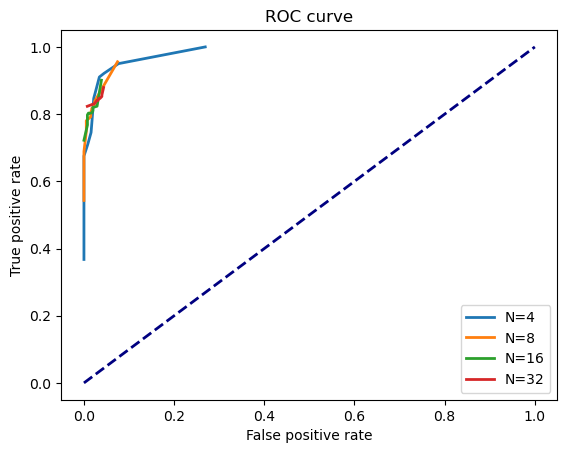

Best pUnseen:  0.2
Best ratio:  0.9477726574500768


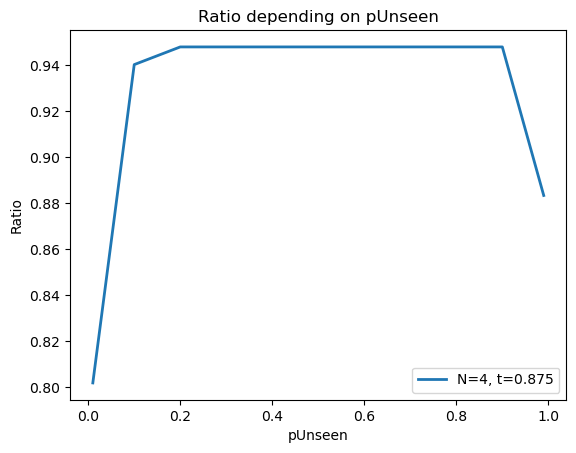

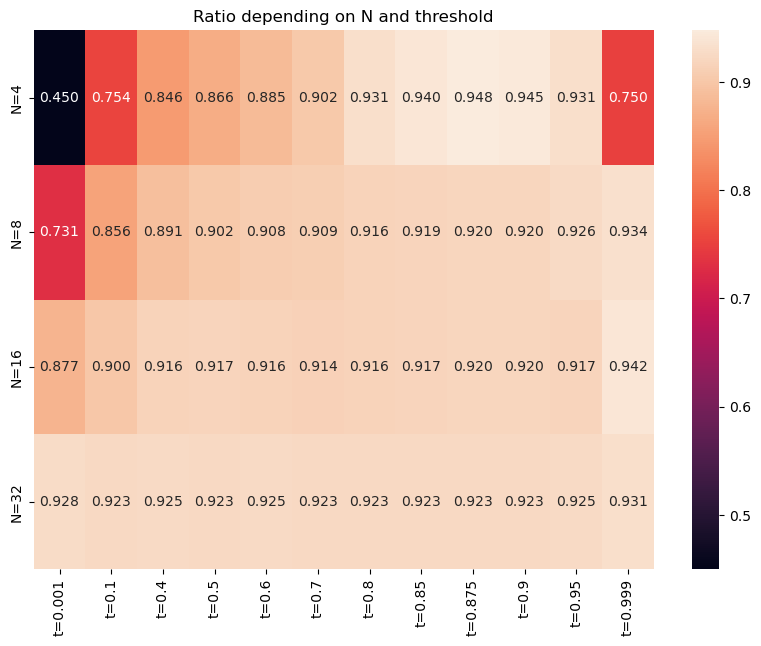

In [77]:
# Test the performance of the SPAM filter on the testing folder
displayPerformance(N, threshold, pUnseen, testingFolder)

# Validate model

N =  4  Threshold =  0.001  Ratio =  0.4984567901234568  FPR =  0.0  TPR =  0.3879472693032015
N =  4  Threshold =  0.1  Ratio =  0.7376543209876543  FPR =  0.0  TPR =  0.5478723404255319
N =  4  Threshold =  0.4  Ratio =  0.8348765432098766  FPR =  0.011661807580174927  TPR =  0.6622950819672131
N =  4  Threshold =  0.5  Ratio =  0.8564814814814815  FPR =  0.011204481792717087  TPR =  0.6941580756013745
N =  4  Threshold =  0.6  Ratio =  0.8888888888888888  FPR =  0.013157894736842105  TPR =  0.75
N =  4  Threshold =  0.7  Ratio =  0.9027777777777778  FPR =  0.015345268542199489  TPR =  0.7782101167315175
N =  4  Threshold =  0.8  Ratio =  0.933641975308642  FPR =  0.01694915254237288  TPR =  0.8468085106382979
N =  4  Threshold =  0.85  Ratio =  0.9521604938271605  FPR =  0.02097902097902098  TPR =  0.8995433789954338
N =  4  Threshold =  0.875  Ratio =  0.9537037037037037  FPR =  0.027522935779816515  TPR =  0.9150943396226415
N =  4  Threshold =  0.9  Ratio =  0.9506172839506173  F

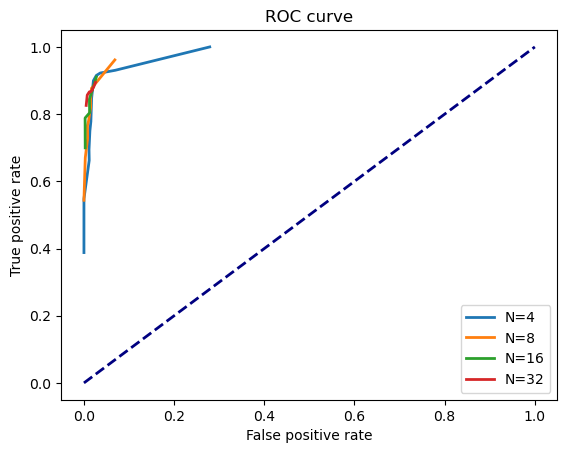

Best pUnseen:  0.8
Best ratio:  0.9552469135802469


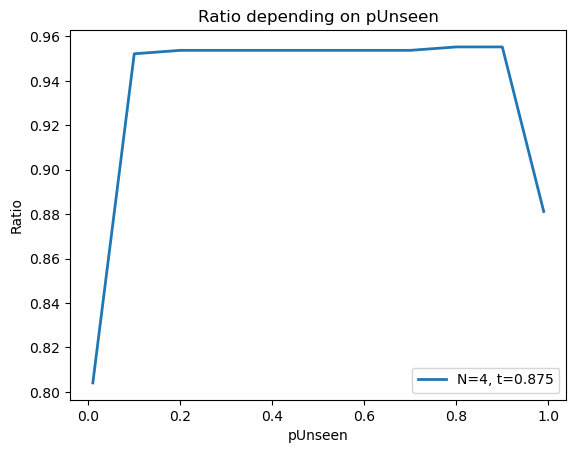

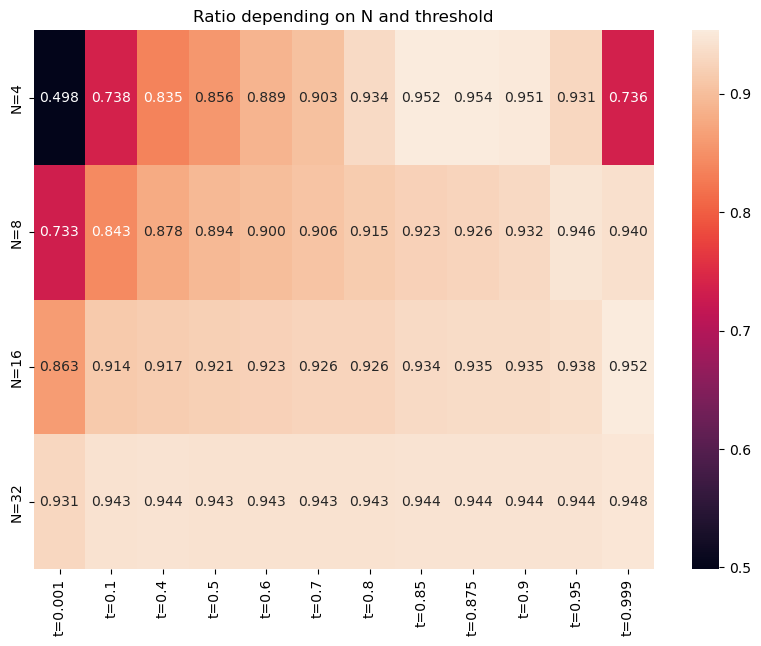

In [78]:
# Validate the performance of the SPAM filter on the validation folder
displayPerformance(N, threshold, pUnseen, validationFolder)